<a href="https://colab.research.google.com/github/alleyex/tensorflow_lab/blob/main/predicting_sunspots_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format = '-' , start = 0, end = None, title = None, xlabel = None, ylabel = None, legend = None):
  """
  visualizes time series data

  Args:
    x (array of int): contains values for the x-axis
    y (array of int or tuple of arrays): contains values for the y-axis
    format (string): line style when plotting the graph
    start (int): first time step to plot
    end (int): last time step to plot
    title (string): title of the plot
    xlabel (string): label for the x-axis
    ylabel (string): label for the y-axis
    legend (list of strings): legend for the plot
  """

  # Setup dimensions of the graph figure
  plt.figure(figsize = (10, 6))

  # Check if there ara more than two series to plot
  if type(y) is tuple:

    # Look over the y elements
    for y_curr in y:

      # Plot the x and current y values
      plt.plot(x[start: end], y_curr[start: end], format)

  else:

    # Plot the x and current y values
    plt.plot(x[start: end], y[start: end], format)

  # Label the x-axis
  plt.xlabel(xlabel)

  # label the y-axis
  plt.ylabel(ylabel)

  # Set the title
  plt.title(title)

  # Set the legend
  if legend:
    plt.legend(legend)

  plt.grid(True)

  # Draw the graph on screen
  plt.show()


In [3]:
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-05-12 13:46:42--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.161.207, 74.125.126.207, 74.125.132.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.161.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2024-05-12 13:46:42 (103 MB/s) - ‘Sunspots.csv’ saved [70827/70827]



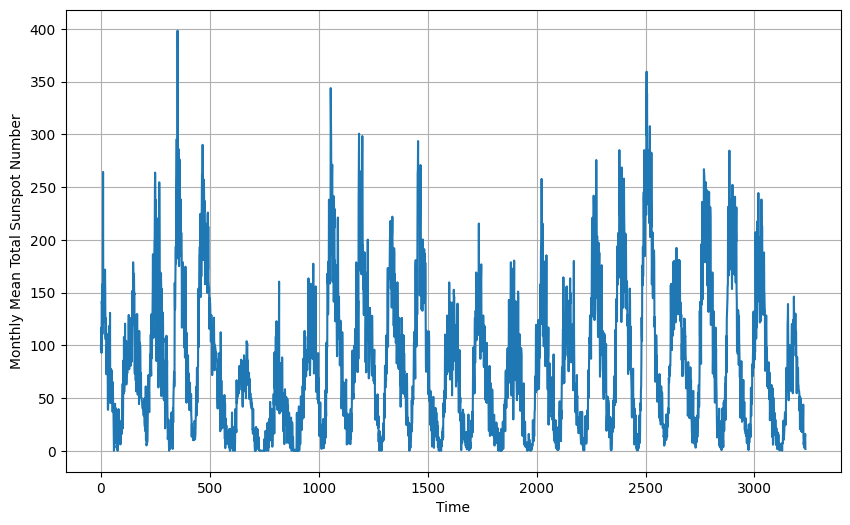

In [4]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter = ',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

  # Convert lists to numpy arrays
  time = np.array(time_step)
  series = np.array(sunspots)

  # Preview the data
  plot_series(time, series, xlabel = "Time", ylabel = "Monthly Mean Total Sunspot Number")


In [5]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
# Prepare Features and Labels
def windowed_dataset(series, wondow_size, batch_size, shuffle_buffer):
  """
  Generates dataset windows for training

  Args:
    series (array of int): contains values for the time series
    wondow_size (int): the number of time steps to include in the feature
    batch_size (int): the batch size
    shuffle_buffer (int): buffer size to use for shuffle method

  Returns:
    dataset (tf.data.Dataset): TF Dataset containing time windows
  """

  # Generate a TF Dataset from the series values
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Window the data but only take those with the specified size
  dataset = dataset.window(wondow_size + 1, shift = 1, drop_remainder = True)

  # Flatten the windows by putting its elements in a single batch
  dataset = dataset.flat_map(lambda window: window.batch(wondow_size + 1))

  # Create tuples of features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Shuffle the windows
  dataset = dataset.shuffle(shuffle_buffer)

  # Create batches of windows
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


In [7]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [9]:
# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'causal', input_shape = [window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences = True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation = 'relu'),
    tf.keras.layers.Dense(10, activation = 'relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 30)                1950      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
 lambda_1 (Lambda)           (None, 1)                

In [10]:
# Get initial weights
init_weights = model.get_weights()

In [14]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer)

# Train in model
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])


Epoch 1/100
93/93 [==============================] - 9s 13ms/step - loss: 57.4321 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 51.4456 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 47.4881 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 44.4219 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 13ms/step - loss: 41.9913 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 12ms/step - loss: 39.9062 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 8ms/step - loss: 37.9748 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 36.1955 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 8ms/step - loss: 34.6446 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 8ms/step - loss: 33.1879 - lr: 2.8184e-08
Epoch 11/100
93/

(1e-08, 0.001, 0.0, 30.0)

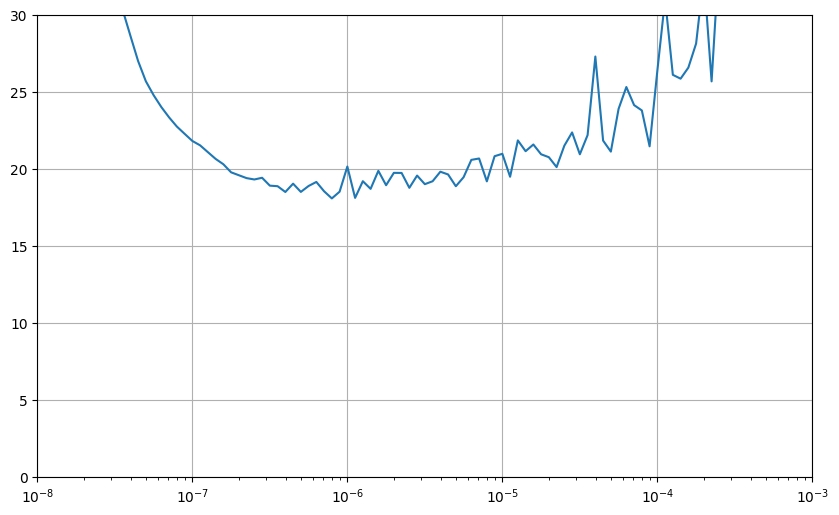

In [19]:
# Define the learning rate array
lrs = 1e-8 * 10**(np.arange(100) / 20)

# Set the figure size
plt.figure(figsize = (10, 6))

# Set the grid
plt.grid(True)

# plot the loss in log scale
plt.semilogx(lrs, history.history['loss'])

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 30])


In [20]:
# Reset states generated by keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [24]:
# Set the learning rate
learning_rate = 8e-7

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss = tf.keras.losses.Huber(), optimizer = optimizer, metrics = ['mae'])


In [27]:
# Train the model
history = model.fit(train_set, epochs = 100)

Epoch 1/100
93/93 [==============================] - 1s 10ms/step - loss: 16.0007 - mae: 16.4866
Epoch 2/100
93/93 [==============================] - 1s 9ms/step - loss: 16.1415 - mae: 16.6292
Epoch 3/100
93/93 [==============================] - 1s 9ms/step - loss: 15.9376 - mae: 16.4255
Epoch 4/100
93/93 [==============================] - 1s 9ms/step - loss: 15.9522 - mae: 16.4409
Epoch 5/100
93/93 [==============================] - 2s 14ms/step - loss: 15.9856 - mae: 16.4739
Epoch 6/100
93/93 [==============================] - 1s 12ms/step - loss: 15.9329 - mae: 16.4214
Epoch 7/100
93/93 [==============================] - 1s 9ms/step - loss: 16.1197 - mae: 16.6064
Epoch 8/100
93/93 [==============================] - 1s 9ms/step - loss: 15.8486 - mae: 16.3368
Epoch 9/100
93/93 [==============================] - 1s 9ms/step - loss: 15.8563 - mae: 16.3444
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 15.8750 - mae: 16.3638
Epoch 11/100
93/93 [================

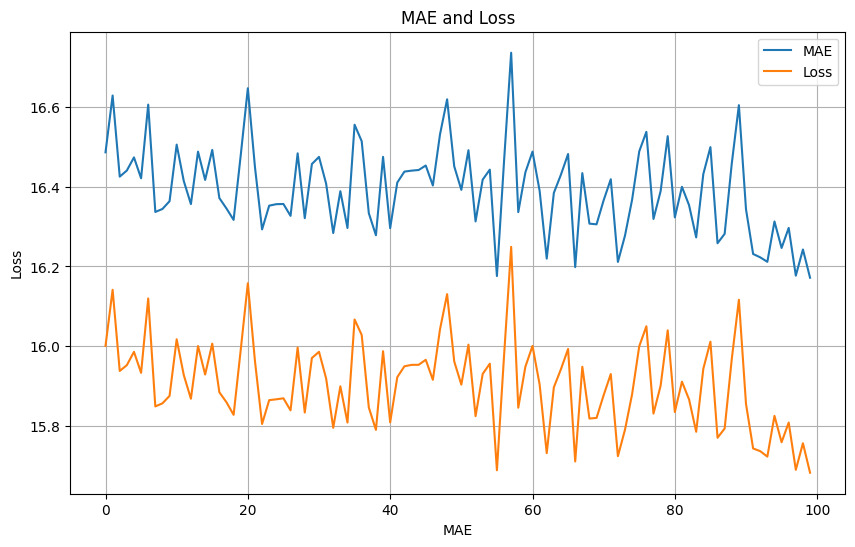

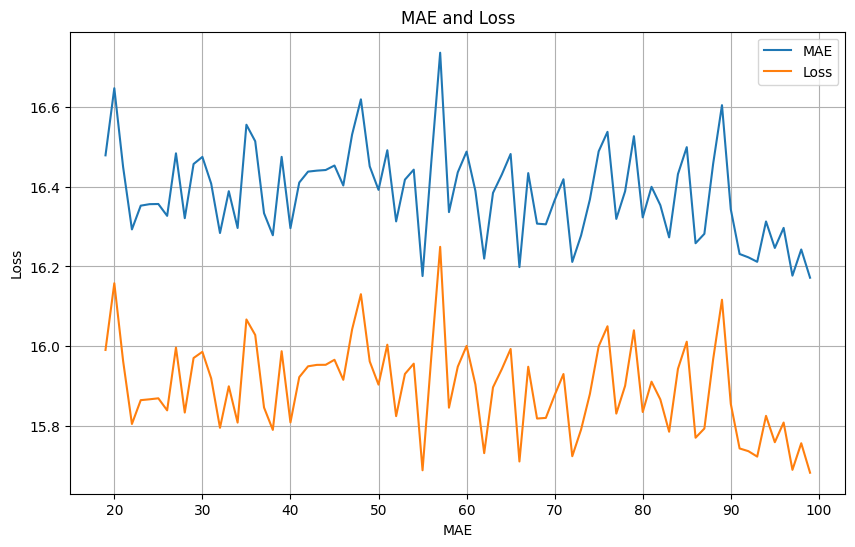

In [28]:
# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plot mae and loss
plot_series(x = epochs, y = (mae, loss), title = "MAE and Loss", xlabel = "MAE", ylabel = "Loss", legend = ["MAE", "Loss"])

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(x = epochs_zoom, y = (mae_zoom, loss_zoom), title = "MAE and Loss", xlabel = "MAE", ylabel = "Loss", legend = ["MAE", "Loss"])

